### I markdown fanno riferimento alle celle appena sotto, leggili o cerca #SOFIA se vuoi sbrigarti

Ho aggiunto bnstruct per Asia e igraph per i plot + sto comando utile per non avere quell'output fastidioso delle librerie

In [1]:
library(bnlearn) |> suppressPackageStartupMessages()
library(Rgraphviz) |> suppressPackageStartupMessages()
library(parallel) |> suppressPackageStartupMessages()
library(tidyverse) |> suppressPackageStartupMessages()
library(dplyr) |> suppressPackageStartupMessages()
library(igraph) |> suppressPackageStartupMessages()
library(bnstruct) |> suppressPackageStartupMessages()
### dataset needs to be preprocessed because  for example had values as factors. My functions does not work w/factorslearning.test

Non ho toccato niente

In [3]:
node.values <- function(dataset, parents) {
    # retrieves the unique values of the nodes
    #return a list of vectors, 
    # each vector contains the unique values of the corresponding node
    output <- list()
    for (kk in seq_along(parents)) {
        node <- parents[kk]
        node.vals <- unique(dataset[[node]]) #it was levels()
        output[[kk]] <- node.vals
    }
    return(output)
}

Guarda la riga con #SOFIA. Chat suggeriva anche il "Laplace smoothing" ma non l'ho ancora provato (riga sotto quella #SOFIA)

In [4]:
fastalphaijk <- function(i, pii, dataset, nodes.order) {
    actual_node <- nodes.order[i]
    all.nodes <- c(pii, actual_node)
    subset <- dataset[all.nodes]
    unique.instantiations <- expand.grid(node.values(dataset, all.nodes))
    colnames(unique.instantiations) <- colnames(subset)
    subset.counted <- subset |> group_by(across(everything())) |> summarise(n = n(), .groups="drop")
    checking <-  left_join(unique.instantiations, subset.counted, by=colnames(subset), na_matches="na")  |> arrange(across(-last_col()))
    checking$n[is.na(checking$n)]<- 0    # SOFIA
    #checking$n <- checking$n + 1   Laplace smoothing
    #print(checking)
    #cat("\n\n[fastalphaijk] actual_node:", actual_node)
    #cat("\n[fastalphaijk] pii:", pii)
    #cat("\n[fastalphaijk] all.nodes:", all.nodes)
    #cat("\n[fastalphaijk] unique.instantiations:\n")
    #print(unique.instantiations)
    #cat("\n[fastalphaijk] counted subset:\n")
    #print(subset.counted)
    cat("\n[fastalphaijk] checking (after join):\n")
    print(checking)
    return(checking$n)
}

Allora: (commentata trovi la versione precedente delle righe che ho modificato)
- aggiunto quel `if` iniziale
- aggiunto log ovunque per non far divergere
- boh questo di base e sembra workare

In [5]:
# debugging
k2helper <- function(i, pii, dataset, nodes.order) {
    # SOFIA
    if (length(pii) == 0) {
        phi_i <- data.frame(dummy = 1)  # fake column to avoid 0-row grid
        q_i <- 1
    } else {
        phi_i <- expand.grid(node.values(dataset, pii))
        q_i <- nrow(phi_i)
    }
    
    #phi_i <- expand.grid(node.values(dataset, pii))
    #cat("\nphi.i")
    #print( phi_i)
    #cat("\nlen phi.i")
    #print(length(phi_i))
    q_i <- dim(phi_i)[1]
    #cat("\nqi.i", q_i)
    nodes <- colnames(dataset)
    #cat("\nnodes", nodes)
    i.th.node <- nodes[i]
    #cat("\nithnode", i.th.node)
    v_i <- node.values(dataset, i.th.node)
    #cat("\nvi")
    #print( v_i)
    r_i <- length(v_i[[1]])
    #cat("\nri", r_i)
    
    individual_alphas <- fastalphaijk(i, pii, dataset, nodes.order) # works good
    cat("\nindividual alphas:",individual_alphas)
    #aijk <- prod(factorial(individual_alphas)) ## SOFIA
    #aijk <- exp(sum(lfactorial(individual_alphas)))

    grouping_alphas <- matrix(individual_alphas, nrow=r_i) # to get the right Nijs
    nij <- colSums(grouping_alphas)
    print(nij)
    
    #produttoria_alpha <- prod(factorial(individual_alphas))   SOFIA
    log_produttoria_alpha <- sum(lfactorial(individual_alphas))
    #numeratore <- factorial(r_i-1)
    #denominatore <- factorial(nij+r_i-1)
    log_numeratore <- sum(lfactorial(rep(r_i - 1, q_i)))  # SOFIA
    log_denominatore <- sum(lfactorial(nij + r_i - 1))
    
    #out <- prod((numeratore/denominatore))*produttoria_alpha
    log_result <- log_numeratore - log_denominatore + log_produttoria_alpha
    log_out <- exp(log_result)
    cat("\nproduttoria_alpha",log_produttoria_alpha)
    log_frazione <- exp(log_numeratore-log_denominatore)
    print(log_frazione)

    cat("\nk2helper → i:", i, "pii:", pii, "→ score:", log_out)
    return(log_out)
}

Aggiunto:
- Sys.time che ci servirà dopo per valutare prestazioni
- `edges` che contiene gli edges lol da plottare dopo

In [6]:
k2 <- function(dataset, nodes.order, upperbound) {

    start <- Sys.time()  # SOFIA
    edges <- list()  # ← new: store edges here  SOFIA
    
    nodes <- colnames(dataset)
    for (i in seq_along(nodes.order)) {
        actual_node <- nodes.order[i]
        #cat("\n", i,"\n")
        pii <- c()
        p.old <- k2helper(i, pii,dataset, nodes.order)
        #cat("\n ",p.old, "\n should be ", 1/2772)
        proceed <- TRUE
        cat("\ni::",i, "\n")
        while (proceed && length(pii) < upperbound) {
            predecessors_idx <- i-1
            predecessors <- nodes.order[0:predecessors_idx]
            cat("\npredecessors::", predecessors, " pii:: ", pii)
            piiuz <- setdiff(predecessors, pii)
            if (length(piiuz) > 1) {
                daddy.s.probs <- c()
                for (daddy in seq_along(piiuz)) {
                    p.new <- k2helper(i, piiuz[daddy], dataset, nodes.order)
                    daddy.s.probs <- c(daddy.s.probs, p.new)
                }
                p.new <- max(daddy.s.probs)
                genitore <-  piiuz[daddy.s.probs == p.new]
            } else {
                p.new <- k2helper(i, piiuz, dataset, nodes.order)
                genitore <- piiuz
            }
            cat("\npiiuz:: ",piiuz,"\np.old:: ", p.old, "\np.new:: ", p.new)
            #roof <- roof+1
            if (p.new > p.old) {
                p.old <- p.new
                pii <- c(pii, genitore)
                #ifelse(roof>length(nodes)^length(nodes), proceed <- FALSE, proceed <- TRUE)
            } else  {
                proceed <- FALSE
            }
        }
        cat('\nNode', nodes.order[i], '--> Parents:', pii,'\n') 
        
        # Store edges: each pii is a parent of actual_node  SOFIA
        if (length(pii) > 0) {
            for (parent in pii) {
                edges[[length(edges) + 1]] <- c(parent, actual_node)
            }
        }
    }
    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    cat("\nExecution Time:", execution_time, "s")

    # Convert to matrix or return edge list
    edge_matrix <- do.call(rbind, edges)
    
    return(edge_matrix)
}

Qua provo con asia ma non va, sotto c'è anche il dummy che invece va bene

In [7]:
asia_dataset <- asia()
asia_df <- as.data.frame(raw.data(asia_dataset))

In realtà lo score non è *sempre* zero quindi meglio di prima

In [8]:
edges <- k2(dataset=asia_df, upperbound=2, nodes.order=colnames(asia_df))


[fastalphaijk] checking (after join):
  V1    n
1  1 4953
2  2 5047

individual alphas: 4953 5047[1] 10000

produttoria_alpha 75182.73[1] 0

k2helper → i: 1 pii: → score: 0
i:: 1 

predecessors::   pii:: 
[fastalphaijk] checking (after join):
  V1    n
1  1 4953
2  2 5047

individual alphas: 4953 5047[1] 10000

produttoria_alpha 75182.73[1] 0

k2helper → i: 1 pii:  → score: 0
piiuz::   
p.old::  0 
p.new::  0
Node V1 --> Parents: 

[fastalphaijk] checking (after join):
  V2    n
1  1 9438
2  2  562

individual alphas: 9438 562[1] 10000

produttoria_alpha 79949.17[1] 0

k2helper → i: 2 pii: → score: 0
i:: 2 

predecessors:: V1  pii:: 
[fastalphaijk] checking (after join):
  V1 V2    n
1  1  1 4918
2  1  2   35
3  2  1 4520
4  2  2  527

individual alphas: 4918 35 4520 527[1] 4953 5047

produttoria_alpha 73292.06[1] 0

k2helper → i: 2 pii: V1 → score: 0
piiuz::  V1 
p.old::  0 
p.new::  0
Node V2 --> Parents: 

[fastalphaijk] checking (after join):
  V3    n
1  1 5419
2  2 4581

individ

### Asia Dataset

Questo serve dopo per plottare

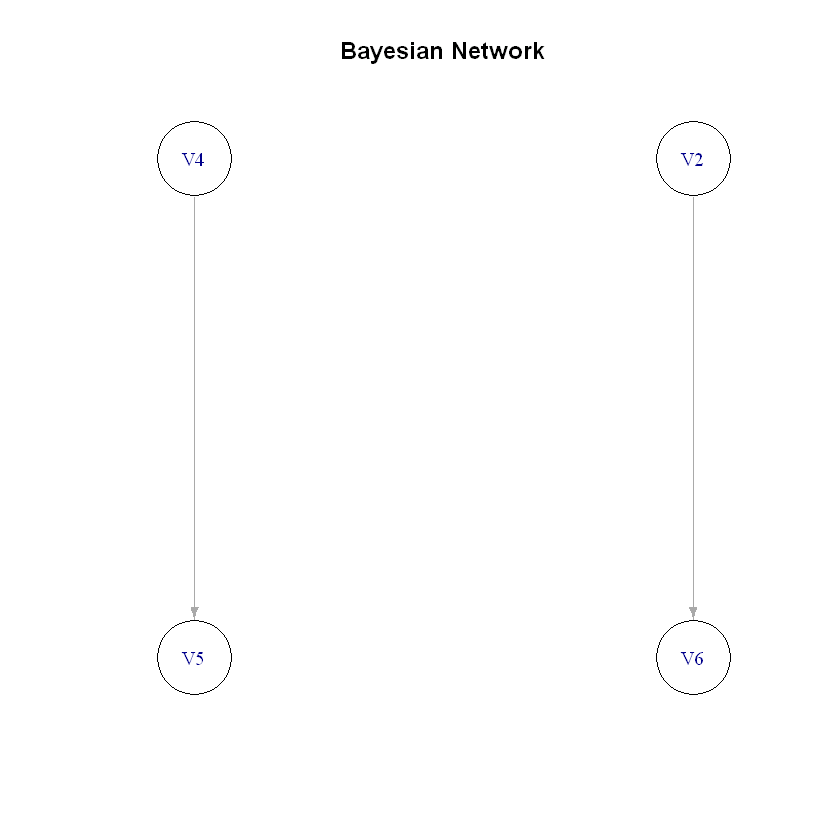

In [9]:
# Convert to graph
g <- graph_from_edgelist(edges, directed = TRUE)

# Plot it
plot(g,
     vertex.color = "white",
     vertex.size = 30,
     edge.arrow.size = 0.5,
     layout = layout_as_tree,
     main = "Bayesian Network")

Questo dà la struttura teorica della rete che dovremmo ottenere (i'm not sure about it)

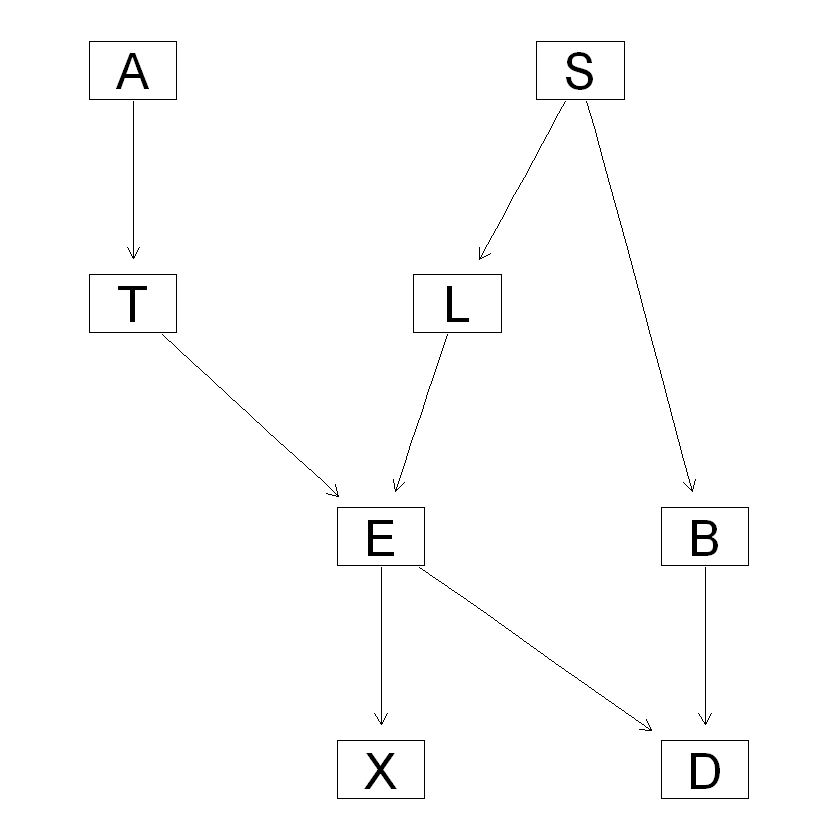

In [10]:
data(asia)
# create and plot the network structure.
dag = model2network("[A][S][T|A][L|S][B|S][D|B:E][E|T:L][X|E]")
graphviz.plot(dag)

Se vuoi provare soddisfazione runna questo che va ;)

### Dummy Dataset


[fastalphaijk] checking (after join):
  x1 n
1  0 5
2  1 5

individual alphas: 5 5[1] 10

produttoria_alpha 9.574983[1] 2.505211e-08

k2helper → i: 1 pii: → score: 0.0003607504
i:: 1 

predecessors::   pii:: 
[fastalphaijk] checking (after join):
  x1 n
1  0 5
2  1 5

individual alphas: 5 5[1] 10

produttoria_alpha 9.574983[1] 2.505211e-08

k2helper → i: 1 pii:  → score: 0.0003607504
piiuz::   
p.old::  0.0003607504 
p.new::  0.0003607504
Node x1 --> Parents: 

[fastalphaijk] checking (after join):
  x2 n
1  0 5
2  1 5

individual alphas: 5 5[1] 10

produttoria_alpha 9.574983[1] 2.505211e-08

k2helper → i: 2 pii: → score: 0.0003607504
i:: 2 

predecessors:: x1  pii:: 
[fastalphaijk] checking (after join):
  x1 x2 n
1  0  0 4
2  0  1 1
3  1  0 1
4  1  1 4

individual alphas: 4 1 1 4[1] 5 5

produttoria_alpha 6.356108[1] 1.929012e-06

k2helper → i: 2 pii: x1 → score: 0.001111111
piiuz::  x1 
p.old::  0.0003607504 
p.new::  0.001111111
predecessors:: x1  pii::  x1
[fastalphaijk] checking

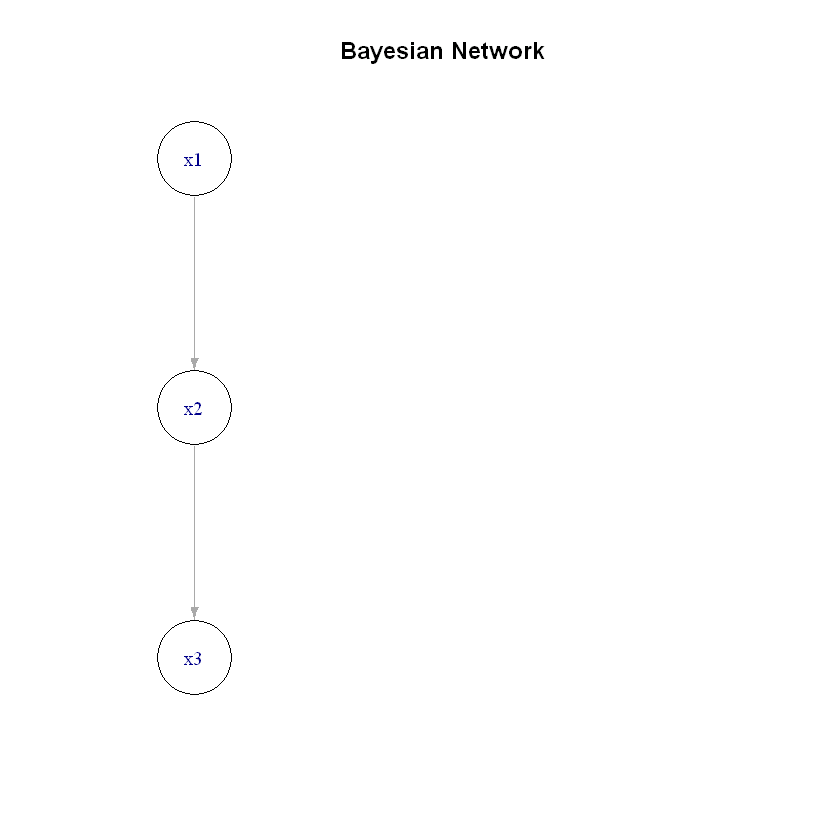

In [11]:
df <- data.frame(x1=c(1,1,0,1,0,0,1,0,1,0), x2=c(0,1,0,1,0,1,1,0,1,0), x3=c(0,1,1,1,0,1,1,0,1,0))

edges <- k2(dataset=df, upperbound=2, nodes.order=colnames(df))

# Convert to graph
g <- graph_from_edgelist(edges, directed = TRUE)

# Plot it
plot(g,
     vertex.color = "white",
     vertex.size = 30,
     edge.arrow.size = 0.5,
     layout = layout_as_tree,
     main = "Bayesian Network")

Al momento con Child non ho ancora fatto nulla

### Child Dataset

In [ ]:
library(bnstruct) |> suppressPackageStartupMessages()

In [ ]:
dataset <- child()
child_df <- as.data.frame(raw.data(dataset))

In [ ]:
class(dataset)

In [ ]:
child <- read_csv('https://www.ccd.pitt.edu/wiki/images/CHILD10k.csv', show_col_types = FALSE)

In [ ]:
child_df <- as.data.frame(child)
colnames(child_df)
head(child_df)